# 🔧 环境配置和检查

## 概述
本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：
- 使用统一的conda环境
- 通过国内镜像源快速安装依赖
- 加速模型下载
- 检查系统配置

## 配置步骤
1. **Conda环境管理** - 激活统一的学习环境
2. **包管理器优化** - 配置pip使用清华镜像源
3. **模型下载加速** - 设置HuggingFace镜像代理
4. **系统环境诊断** - 检查硬件和软件配置


In [ ]:
# 1. 激活conda环境
%%script bash
# 初始化 conda
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action
conda env list


In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-2/state-reducers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 状态归并（State Reducers）

## 回顾

我们已经学习了在 LangGraph 中定义状态（state）模式的几种方式：`TypedDict`、`Pydantic`、以及 `Dataclasses`。

## 学习目标

本节将系统讲解“归并器（reducer）”的概念与用法。Reducer 用于指定：当多个节点对同一状态键（或通道）进行更新时，图应如何对这些更新进行合并，从而生成一致且可预期的最终状态。面向初学者的理解要点是：节点总是返回“增量状态”，reducer 负责把这些增量按既定规则整合到全局状态中。

In [1]:
%%capture --no-stderr
# %pip install --quiet -U langchain_core langgraph
%pip install langgraph==0.6.7 langchain_core==0.3.75

## 默认的“覆盖式”更新

下面用 `TypedDict` 来定义状态结构，演示默认的更新策略：如果未指定 reducer，后写入的值将覆盖同名键的先前值。

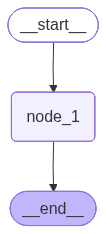

In [2]:
# 说明：本单元演示最基础的状态（State）定义与节点更新。
# - 使用 TypedDict 定义图的状态结构。
# - 默认更新策略为“覆盖”（overwrite），即同名键的值被后写入的结果覆盖。
# - 面向初学者要点：每个节点返回的是“增量（partial）状态”，图会据此合并成新状态。

from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # 状态模式：仅包含一个整型键 foo
    foo: int

def node_1(state):
    # 节点逻辑：读取状态中的 foo，自增 1 后作为增量返回
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# 构建图（Graph）：注册节点与边
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# 定义执行逻辑：从 START 进入 node_1，随后到 END 结束
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# 编译图
graph = builder.compile()

# 可视化图结构（Mermaid PNG）
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"foo" : 1})

---Node 1---


{'foo': 2}

来看这条状态更新语句：`return {"foo": state['foo'] + 1}`。

如前所述，如果未指定 reducer，LangGraph 并不知道你的“首选更新方式”，因此会采用默认策略：覆盖同名键的旧值。

```
return {"foo": state['foo'] + 1}
```

当输入为 `{'foo': 1}` 时，图返回的状态为 `{'foo': 2}`。

## 分支（Branching）

接下来看看分支并发时会发生什么。

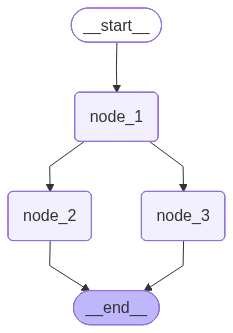

In [4]:
# 说明：本单元演示“分支并发”导致的状态写入冲突。
# - node_1 执行后，同时（同一步）触发 node_2 与 node_3。
# - 二者都返回 {"foo": ...}，默认策略为覆盖（overwrite），同一步对同一键写入多个值会产生歧义。
# - 因此后续执行时会抛出 InvalidUpdateError，提示需要为该键声明归并（reducer）。

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# 构建图
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 执行逻辑：node_1 -> (node_2 并发 node_3) -> END
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# 编译图
graph = builder.compile()

# 可视化图结构
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


这里出现了一个问题！

`node_1` 同时分支到 `node_2` 与 `node_3`。

`node_2` 和 `node_3` 会并行执行（即同一步执行）。

它们在“同一步”都试图更新同一个键，且默认是“覆盖式”更新。

对于图而言，这会造成歧义：到底保留哪一个值？

## 归并器（Reducers）

[Reducer](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) 提供了一种通用方法来解决该歧义问题：它明确规定“如何执行更新”。

在 LangGraph 中，我们可以结合 `Annotated` 类型为某个键声明一个 reducer 函数。

例如，这里我们希望“追加”每个并发节点返回的结果，而不是相互覆盖。Python 内置模块 `operator` 中的 `operator.add` 对列表的作用是“列表拼接”，正好满足这种“把多个更新拼到一起”的语义。

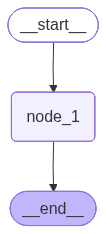

In [6]:
# 说明：通过 Annotated 指定 reducer（归并函数），让同一步对同一键的多次写入可以“合并”。
# - 这里为键 foo 使用 operator.add 作为 reducer；对 list 而言，add 等价于“列表拼接”。
# - 因此多个节点返回的列表将被拼接到一起，而不是互相覆盖。

from operator import add
from typing import Annotated

class State(TypedDict):
    # foo 为整型列表，并使用 add 作为 reducer
    foo: Annotated[list[int], add]

def node_1(state):
    # 返回单元素列表以触发拼接行为
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# 构建图
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# 执行逻辑
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# 编译图
graph = builder.compile()

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

现在，状态键 `foo` 的类型是列表。

借助 `operator.add` 作为 reducer，各节点返回的更新会被“追加”到该列表中（而非覆盖）。

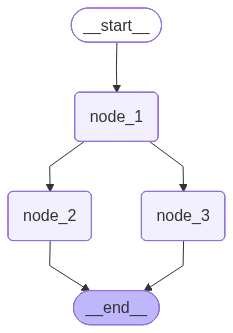

In [8]:
# 说明：在为 foo 指定 add reducer 后，分支并发写入将被安全拼接。
# - node_2、node_3 同一步返回单元素列表，最终状态将把这些列表拼接到 foo 尾部。
# - 示例取“最后一个元素 + 1”仅为演示增量，非严格并发计数方案。

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# 构建图
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 执行逻辑
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# 编译图
graph = builder.compile()

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

可以看到，`node_2` 与 `node_3` 的更新是并发进行的，因为它们处于同一步执行。

In [9]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

接下来，看看当把 `None` 作为 `foo` 的输入会发生什么。

会报错：因为 `operator.add` 试图在 `node_1` 中把 `None` 与列表拼接（`list + None`），从而触发 TypeError。

In [10]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## 自定义归并器（Custom Reducers）

为了解决上述问题，[可以自定义 reducer](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state)。

例如，我们可以编写一个自定义的列表合并逻辑，正确处理单侧或双侧为 `None` 的情况。

In [11]:
# 说明：自定义 reducer，以安全合并列表并兼容 None 输入。
# - reduce_list 对 None 视为 []，从而避免 add 在 list + None 时抛出 TypeError。
# - DefaultState 使用内置 add；CustomReducerState 使用 reduce_list，以获得更鲁棒的行为。

def reduce_list(left: list | None, right: list | None) -> list:
    """安全地合并两个列表，处理任一或两个输入可能为 None 的情况。

    参数：
        left (list | None): 第一个要合并的列表，或为 None。
        right (list | None): 第二个要合并的列表，或为 None。

    返回：
        list: 包含两个输入列表所有元素的新列表。
              如果输入是 None，则被视为空列表。
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    # 使用内置 add（列表拼接），不处理 None
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    # 使用自定义 reduce_list，自动将 None 视为空列表
    foo: Annotated[list[int], reduce_list]

在 `node_1` 中，我们向列表追加元素 2。

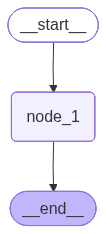

TypeError occurred: can only concatenate list (not "NoneType") to list


In [12]:
# 说明：使用默认 add reducer，在输入 foo=None 时会报错（list 无法与 None 拼接）。

def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# 构建图（默认 add）
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# 执行逻辑
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# 编译图
graph = builder.compile()

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

# 测试：None 作为初始 foo，将触发 TypeError
try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

现在使用我们自定义的 reducer，可以看到不会再抛出错误。

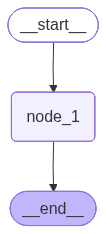

---Node 1---
{'foo': [2]}


In [13]:
# 说明：使用自定义 reduce_list 后，输入 foo=None 将被视为 []，因此不会报错。

# 构建图（自定义 reduce_list）
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# 执行逻辑
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# 编译图
graph = builder.compile()

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

# 测试：None 作为初始 foo，不会抛错
try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## 消息（Messages）

在第 1 模块中，我们演示了如何使用内置 reducer `add_messages` 来管理状态中的消息。

我们也说明过：[在消息场景下，`MessagesState` 是一种便捷用法](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)。

- `MessagesState` 内置了 `messages` 键；
- 同时内置了该键对应的reducer键 `add_messages` ；

两种方式在语义上等价。

下面为了简洁，直接通过 `from langgraph.graph import MessagesState` 使用该类。


In [14]:
# 说明：消息（messages）场景下，可使用内置 reducer add_messages 管理追加/覆盖/删除。
# - CustomMessagesState：显式声明 messages 键及其 add_messages reducer。
# - ExtendedMessagesState：继承 MessagesState（已内置 messages 与 add_messages），再扩展其他键。

from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# 自定义 TypedDict：显式包含 messages 列表，并指定 add_messages 作为 reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# 使用 MessagesState：其已内置 messages 键与 add_messages reducer
class ExtendedMessagesState(MessagesState):
    # 可在此基础上扩展额外的业务键
    added_key_1: str
    added_key_2: str
    # etc

下面进一步介绍 `add_messages` reducer 的使用要点。

In [16]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# 初始消息列表（state.messages 的示例）
initial_messages = [AIMessage(content="您好！有什么可以为您效劳的？", name="Model"),
                    HumanMessage(content="我正在寻找有关海洋生物学的信息。", name="Lance")
                   ]

# 新增消息：将被追加到列表尾部（add_messages 的追加语义）
new_message = AIMessage(content="好的，我很乐意帮忙。您具体对什么感兴趣？", name="Model")

# 测试：返回新列表，包含原消息 + 新消息
add_messages(initial_messages , new_message)

[AIMessage(content='您好！有什么可以为您效劳的？', additional_kwargs={}, response_metadata={}, name='Model', id='4588324a-87b3-47e1-8961-ab6e1e146694'),
 HumanMessage(content='我正在寻找有关海洋生物学的信息。', additional_kwargs={}, response_metadata={}, name='Lance', id='f7ccee30-b5a1-44ab-bd7d-5f7974cc48af'),
 AIMessage(content='好的，我很乐意帮忙。您具体对什么感兴趣？', additional_kwargs={}, response_metadata={}, name='Model', id='adb9bd1c-91d0-4fa3-8a0c-daeca5426307')]

可以看到，`add_messages` 支持将新消息“追加”到状态中的 `messages` 列表。

### 覆盖（Re-writing）

使用 `add_messages` 时有个常用技巧：

如果传入的新消息与列表中某条消息 `id` 相同，则会触发“覆盖”语义——同 `id` 的消息内容会被替换更新。

In [17]:
# 初始列表：包含两条消息，id 分别为 1 和 2
initial_messages = [AIMessage(content="您好！有什么可以为您效劳的？", name="Model", id="1"),
                    HumanMessage(content="我正在寻找有关海洋生物学的信息。", name="Lance", id="2")
                   ]

# 新消息：id 与已有消息（id=2）相同 ——> 触发“覆盖”语义（同 id 覆盖）
new_message = HumanMessage(content="我正在寻找有关鲸鱼的信息，特别是", name="Lance", id="2")

# 测试：返回的新列表中，id=2 的消息将被新内容覆盖
add_messages(initial_messages , new_message)

[AIMessage(content='您好！有什么可以为您效劳的？', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content='我正在寻找有关鲸鱼的信息，特别是', additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

### 删除（Removal）

`add_messages` 还支持[删除消息](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/)。

做法是：使用 `langchain_core` 提供的 [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html)（仅需提供要删除消息的 `id`），`add_messages` 会据此实现删除语义。

In [19]:
from langchain_core.messages import RemoveMessage

# 消息列表示例（含 4 条消息）
messages = [AIMessage("你好。", name="Bot", id="1")]
messages.append(HumanMessage("你好。", name="Lance", id="2"))
messages.append(AIMessage("你之前说你在研究海洋哺乳动物，对吗？", name="Bot", id="3"))
messages.append(HumanMessage("是的，我知道鲸鱼。但我还应该了解哪些其他的呢？", name="Lance", id="4"))

# 待删除列表：构造 RemoveMessage（仅需 id），交由 add_messages 实现删除语义
# 这里示例删除前两条（id=1,2）
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [20]:
# 通过 add_messages 应用删除操作：返回的新列表将不包含 id=1,2 的消息
add_messages(messages , delete_messages)

[AIMessage(content='你之前说你在研究海洋哺乳动物，对吗？', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='是的，我知道鲸鱼。但我还应该了解哪些其他的呢？', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

可以看到，`delete_messages` 中标注的 id=1、2 的消息已被删除。

稍后你会在更完整的图中看到这些技巧的实际应用。